In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import import_ipynb
from feeds import BackFeed,DataFeed
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import graphviz
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

importing Jupyter notebook from feeds.ipynb
importing Jupyter notebook from synfeed.ipynb
importing Jupyter notebook from india_calendar.ipynb
importing Jupyter notebook from featfuncs.ipynb


In [2]:
hp_version = 11
test_path = os.path.join('results', f'hp_{hp_version}', 'test', 'bt.pkl')
feed_path = os.path.join('..', 'algodata', f'btfeed_hp_{hp_version}_test.pkl')

data_1 = pickle.load(open(test_path, 'rb'))['SYN']
feed = pickle.load(open(feed_path, 'rb')).data['SYN']

In [3]:
feed['row_num'] = feed['row_num'].apply(lambda x: x if x<75 else x-75)

### high - low, open - close, open - open prev, sma 20 - sma 10, open - high, slope (window size on all the features, slopes on all the features)

In [4]:
columns = ['datetime', 'Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume',
       'row_num', 'Open_n', 'High_n', 'Low_n', 'Close_n', 'Volume_n', 'SMA_10',
       'SMA_20', 'VOL_SMA_20', 'RSI_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
       'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'VWAP_D', 'MOM_30', 'CMO_14', 'error', 'sym']

columns_to_use = ['Open', 'High', 'Low', 'Close', 'Volume', 'row_num', 'Open_n', 
                  'High_n', 'Low_n', 'Close_n', 'Volume_n', 'SMA_10',
       'SMA_20', 'VOL_SMA_20', 'RSI_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
       'BBB_5_2.0', 'BBP_5_2.0', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'VWAP_D', 'MOM_30', 'CMO_14']

In [5]:
def check_numeric(df, col):
    return df[col].dtype in ['float64', 'int64']

def difference_cols(df, a, b):
    df[f'{a}-{b}'] = df[a] - df[b]
    return df, f'{a}-{b}'

def get_ma_base_string(s):
    idx = s.find('_ma_')
    if idx == -1:
        return None
    return s[:idx]

def moving_avg(df, col, window_size=3, center=False):
    col_name = f'{col}_ma_{window_size}'
    df[col_name] = df[col].rolling(window_size, min_periods=1, center=center).mean()
    return df, col_name

def slope(df, col, window):
    col_name = f'{col}_slope_{window}'
    df[col_name] = df[col].diff(periods=window).fillna(df[col])/window
    return df, col_name

def max_change_helper(seq):
    ans = []
    tracker = {i:0 for i in range(seq[-1]+1)}
    for i in seq:
        tracker[i] += 1
        ans.append(tracker[i])
    return ans

def max_change(df, col):
    inc_tracker = df[col].diff().lt(0).cumsum().values
    dec_tracker = df[col].diff().gt(0).cumsum().values
    
    inc_values = max_change_helper(inc_tracker)
    dec_values = max_change_helper(dec_tracker)
    
    combined = [inc_values[i]-1 if inc_values[i] >= dec_values[i] \
                else -dec_values[i]+1 for i in range(len(inc_values))]
    
    col_name = f'{col}_changelen'
    df[col_name] = combined
    return df, col_name

def discretize(df, col):
    stats = df[col].describe()
    low_thresh, high_thresh = stats['25%'], stats['75%']
    df[f'{col}_val'] = df[col].apply(lambda x: 0 if x<=low_thresh else 2 if x>=high_thresh else 1)
    df[f'{col}_polarity'] = df[col].apply(lambda x: 1 if x>0 else -1)
    # df[f'{col}_discrete'] = df[f'{col}_val'] + df[f'{col}_polarity']
    return df, [f'{col}_val', f'{col}_polarity'] #, f'{col}_discrete']

In [6]:
feed.head()

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,BBB_5_2.0,BBP_5_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,VWAP_D,MOM_30,CMO_14,error,sym
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,1.000000,1.000000,1.0,1.0,1.0,1.000028,1.0,1.0,-1,0
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,1.000000,1.000000,1.0,1.0,1.0,0.999975,1.0,1.0,-1,0
2022-09-29 09:25:00,2022-09-29 09:25:00,29-Sep-2022,SYN,0.999788,0.999704,0.999788,0.999704,1.0,2,0.999873,...,1.000000,1.000000,1.0,1.0,1.0,0.999922,1.0,1.0,-1,0
2022-09-29 09:30:00,2022-09-29 09:30:00,29-Sep-2022,SYN,0.999682,0.999598,0.999682,0.999598,1.0,3,0.999767,...,1.000000,1.000000,1.0,1.0,1.0,0.999869,1.0,1.0,-1,0
2022-09-29 09:35:00,2022-09-29 09:35:00,29-Sep-2022,SYN,0.999577,0.999492,0.999577,0.999492,1.0,4,0.999661,...,0.059857,0.146535,1.0,1.0,1.0,0.999817,1.0,1.0,-1,0


### Inter-column Differences

In [7]:
subtract_col_names = [('High', 'Low'), ('Open', 'Close'), ('SMA_20', 'SMA_10'), ('Open_n', 'Close_n'), ('High_n', 'Low_n'), ('Open', 'High')]
subtract_cols = []

for cols in subtract_col_names:
    feed, added_col = difference_cols(feed, cols[0], cols[1])
    subtract_cols.append(added_col)
    
feed.head(2)

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,MOM_30,CMO_14,error,sym,High-Low,Open-Close,SMA_20-SMA_10,Open_n-Close_n,High_n-Low_n,Open-High
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,1.0,1.0,-1,0,-0.000085,0.000085,0.0,0.000085,-0.000085,0.000085
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,1.0,1.0,-1,0,-0.000085,0.000085,0.0,0.000085,-0.000085,0.000085


### Moving Average Calculation

In [8]:
window_sizes = [1,5,10,20,50]
pre_avg_cols = columns_to_use + subtract_cols
avg_cols = []

for window in window_sizes:
    for col in pre_avg_cols:
        feed, added_col = moving_avg(feed, col, window_size=window)
        avg_cols.append(added_col)
            
feed.head(2)

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,MACDs_12_26_9_ma_50,VWAP_D_ma_50,MOM_30_ma_50,CMO_14_ma_50,High-Low_ma_50,Open-Close_ma_50,SMA_20-SMA_10_ma_50,Open_n-Close_n_ma_50,High_n-Low_n_ma_50,Open-High_ma_50
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,1.0,1.000028,1.0,1.0,-0.000085,0.000085,0.0,0.000085,-0.000085,0.000085
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,1.0,1.000002,1.0,1.0,-0.000085,0.000085,0.0,0.000085,-0.000085,0.000085


In [9]:
print(len(columns_to_use), len(subtract_cols), len(avg_cols))

26 6 160


### Slopes

In [10]:
pre_slope_cols = columns_to_use + subtract_cols + avg_cols
window_sizes = [1,3,5,10,15]
slope_cols = []

for window in window_sizes:
    for col in pre_slope_cols:
        feed, added_col = slope(feed, col, window=window)
        slope_cols.append(added_col)

feed.head(2)

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,MACDs_12_26_9_ma_50_slope_15,VWAP_D_ma_50_slope_15,MOM_30_ma_50_slope_15,CMO_14_ma_50_slope_15,High-Low_ma_50_slope_15,Open-Close_ma_50_slope_15,SMA_20-SMA_10_ma_50_slope_15,Open_n-Close_n_ma_50_slope_15,High_n-Low_n_ma_50_slope_15,Open-High_ma_50_slope_15
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,0.066667,0.066669,0.066667,0.066667,-0.000006,0.000006,0.0,0.000006,-0.000006,0.000006
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,0.066667,0.066667,0.066667,0.066667,-0.000006,0.000006,0.0,0.000006,-0.000006,0.000006


### Difference between moving averages of different lengths

In [11]:
intra_ma_diff_cols = []

for i in range(len(avg_cols)-1):
    for j in range(i+1, len(avg_cols)):
        colA, colB = avg_cols[i], avg_cols[j]
        baseA, baseB = get_ma_base_string(colA), get_ma_base_string(colB)
        if baseA != baseB: continue
        
        feed, added_col = difference_cols(feed, colA, colB)
        intra_ma_diff_cols.append(added_col)
    
feed.head(2)

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,MACDs_12_26_9_ma_20-MACDs_12_26_9_ma_50,VWAP_D_ma_20-VWAP_D_ma_50,MOM_30_ma_20-MOM_30_ma_50,CMO_14_ma_20-CMO_14_ma_50,High-Low_ma_20-High-Low_ma_50,Open-Close_ma_20-Open-Close_ma_50,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50,High_n-Low_n_ma_20-High_n-Low_n_ma_50,Open-High_ma_20-Open-High_ma_50
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get Increasing/Decreasing Length

In [12]:
pre_change_cols = columns_to_use + subtract_cols + avg_cols + slope_cols + intra_ma_diff_cols
change_cols = []

for col in pre_change_cols:
    feed, added_col = max_change(feed, col)
    change_cols.append(added_col)
    
feed.head(2)

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,MACDs_12_26_9_ma_20-MACDs_12_26_9_ma_50_changelen,VWAP_D_ma_20-VWAP_D_ma_50_changelen,MOM_30_ma_20-MOM_30_ma_50_changelen,CMO_14_ma_20-CMO_14_ma_50_changelen,High-Low_ma_20-High-Low_ma_50_changelen,Open-Close_ma_20-Open-Close_ma_50_changelen,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen,Open-High_ma_20-Open-High_ma_50_changelen
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,0,0,0,0,0,0,0,0,0,0
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,1,1,1,1,1,1,1,1,1,1


### Discretization

In [13]:
pre_discrete_cols = pre_change_cols + change_cols
discrete_cols = []

for col in pre_discrete_cols:
    feed, added_cols = discretize(feed, col)
    for added_col in added_cols: discrete_cols.append(added_col)
    
feed.head(2)

,datetime,Date,ticker,Open,High,Low,Close,Volume,row_num,Open_n,...,Open-Close_ma_20-Open-Close_ma_50_changelen_val,Open-Close_ma_20-Open-Close_ma_50_changelen_polarity,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen_val,SMA_20-SMA_10_ma_20-SMA_20-SMA_10_ma_50_changelen_polarity,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen_val,Open_n-Close_n_ma_20-Open_n-Close_n_ma_50_changelen_polarity,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen_val,High_n-Low_n_ma_20-High_n-Low_n_ma_50_changelen_polarity,Open-High_ma_20-Open-High_ma_50_changelen_val,Open-High_ma_20-Open-High_ma_50_changelen_polarity
2022-09-29 09:15:00,2022-09-29 09:15:00,29-Sep-2022,SYN,1.000000,0.999915,1.000000,0.999915,1.0,0,1.000085,...,1,-1,1,-1,1,-1,1,-1,1,-1
2022-09-29 09:20:00,2022-09-29 09:20:00,29-Sep-2022,SYN,0.999894,0.999809,0.999894,0.999809,1.0,1,0.999979,...,1,1,1,1,1,1,1,1,1,1


In [14]:
len(discrete_cols)

5888

### Adding Action Taken by Agent

### 0: Wait, 1: Buy, 2:Sell

In [15]:
feed['Action'] = -5
actions = []

for t in data_1:
    for acts in data_1[t]['acts']:
        a, rn = acts[0], acts[-1]
        actions.append(a)
        if a == -1: a = 2
        feed.loc[(feed['Date']==t) & (feed['row_num']==rn), 'Action'] = a

In [16]:
feed['Action'].value_counts()

-5    5228
 1     490
 2     432
Name: Action, dtype: int64

### Creating Final DataFrame

In [17]:
df = feed[feed['Action']!=-5]
labels = ['buy', 'sell']

### Training a DT

In [18]:
def trainDT(df, cols_to_use, y_col, max_depth=2):
    n = len(df)
    X = df.loc[:, cols_to_use]
    y = df.loc[:, y_col]
    
    X_train, X_test, y_train, y_test = X.iloc[:n//2], X.iloc[n//2:], y.iloc[:n//2].values, y.iloc[n//2:].values

    # Fit the classifier with default hyper-parameters
    clf = DecisionTreeClassifier(max_depth=max_depth)
    model = clf.fit(X_train, y_train)
    
    # DOT data
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=cols_to_use,
                                    class_names=labels,
                                    filled=True)
    # Draw graph
    graph = graphviz.Source(dot_data, format="png")
    preds = clf.predict(X_test)
    cm = pd.DataFrame(confusion_matrix(y_test, preds), columns=labels, index=labels)
    report = classification_report(y_test, preds, target_names=labels)
    
    return graph, cm, report

In [19]:
discrete_non_raw = [col for col in discrete_cols if col.rstrip('_polarity').rstrip('_val') not in columns_to_use]
len(discrete_non_raw)

5836

[INFO] Using 5888 columns!


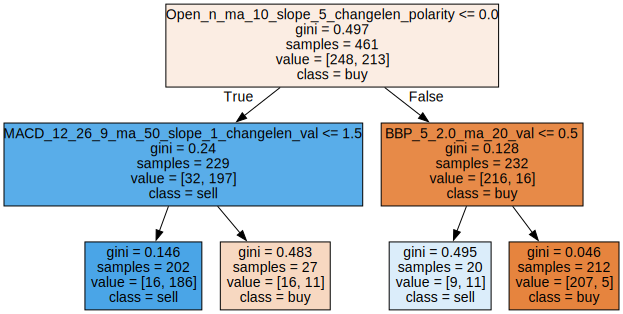

In [20]:
COLS_TO_USE = discrete_cols
print(f'[INFO] Using {len(COLS_TO_USE)} columns!')

graph, cm, report = trainDT(df, COLS_TO_USE, y_col='Action', max_depth=2) 
graph

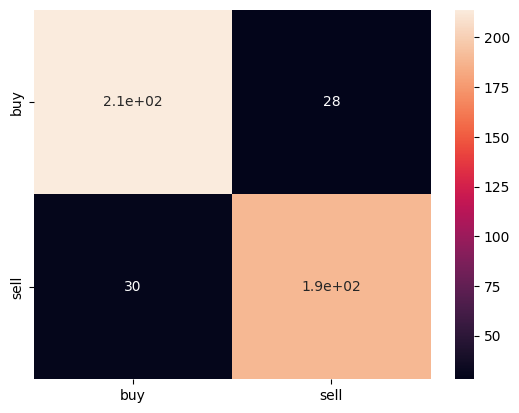

In [21]:
sns.heatmap(cm, annot=True);

In [22]:
print(report)


              precision    recall  f1-score   support

         buy       0.88      0.88      0.88       242
        sell       0.87      0.86      0.87       219

    accuracy                           0.87       461
   macro avg       0.87      0.87      0.87       461
weighted avg       0.87      0.87      0.87       461



#### run the policy from the dt (after uncertainty removal) on real and synthetic data

#### run the rl on real data once more

#### get the optimal policy for real data and make a dt from that

#### Take synthetic rl + optimal real: train dt on different bags of the data, get some featuress, take the top 5 features, train a random forest (to get a policy)

#### don't take an action where the confidence is low (impurity/entropy is high) at the leaf

#### use this policy for testing on the real data

#### use the sequence (curr features, current and past timesteps) to predict the future (predict the correct action). 